In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\scripts")

In [2]:
import numpy as np
import torch
from torch.quasirandom import SobolEngine
tkwargs = {"dtype": torch.double,
           "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
#            "device": torch.device("cpu")
          }
from botorch.models.transforms.outcome import Standardize
import matplotlib.pyplot as plt
from MAB_BO_utils import *

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


In [3]:
# global parameters


d = 1
m = 2*(d+1)
C = 3
BOUNDS = torch.tensor([[-1.0]*(d), [3.0]*(d)])


N_CANDIDATES = 1
SAMPLER = 'cholesky'
N_SAMPLES = 1000
NU = 0.5

N_TRIALS = 3
N_ITERS = 40

picked category: 0


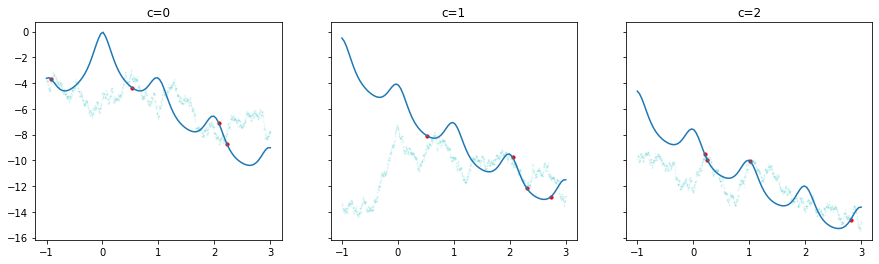

In [4]:
# THOMPSON SAMPLING VISUALIZATION

# define train_X and train_y
train_X = generate_X(m, d, C, BOUNDS, seed=0)
train_y = modified_neg_ackley(train_X)

# normalize X
train_X_normalized = normalize_with_bounds(train_X, BOUNDS)

# initialize model
models = initialize_models(train_X_normalized, train_y, nu=NU, sampler=SAMPLER)



fig, ax = plt.subplots(1, C, figsize=(15, 4), sharey=True)
x = np.linspace(-1, 3, 100)
X = torch.tensor(x).unsqueeze(-1)

for c in range(C):
    
    # PLOT FUNCTION
    categories = torch.tensor([c]*X.shape[0]).unsqueeze(-1)
    X_ = torch.cat([categories, X], dim=-1)
    y = modified_neg_ackley(X_).squeeze(0).detach().numpy()
    ax[c].plot(x, y)
    ax[c].set_title(f'c={c}')
    
    # PLOT DATAPOINTS
    mask = train_X[..., 0] == c
    X_ = train_X[mask, 1:].squeeze(0).detach().numpy()
    y_ = train_y[mask].squeeze(0).detach().numpy()
    ax[c].scatter(X_, y_, s=10, c='r')
    
    # PLOT THOMPSON SAMPLES
    model = models[c]
    _, _, X_, y_ = thompson_sampling(model, d, N_SAMPLES, sampler=SAMPLER)
    categories = torch.tensor([c]*X_.shape[0]).unsqueeze(-1)
    X_ = torch.cat([categories, X_], dim=-1)
    X_ = denormalize_with_bounds(X_, BOUNDS)
    X_ = X_[:, 1:].squeeze(-1).detach().numpy()
    y_ = y_.squeeze(-1).detach().numpy()
    
    ax[c].scatter(X_, y_, c='c', alpha=0.1, s=0.5)
    
    
# picked category
cat = pick_category(models, d, N_SAMPLES, sampler=SAMPLER)
print(f"picked category: {cat}")

In [5]:
# BO LOOP

best_values = torch.empty(N_TRIALS, N_ITERS, **tkwargs)

for t in range(N_TRIALS):
    
    # generate starting dataset
    train_X = generate_X(m, d, C, BOUNDS, seed=t)
    train_y = modified_neg_ackley(train_X)

    
    for i in range(N_ITERS):
        
        print(f"trial {t+1}/{N_TRIALS} | iteration {i+1}/{N_ITERS} | ", end='')
    
        # normalize X 
        train_X_normalized = normalize_with_bounds(train_X, BOUNDS)
        # standardize y
        standardizer = Standardize(1)
        train_y_standardized = standardizer(train_y)[0]

        # initialize model
        models = initialize_models(train_X_normalized, train_y, nu=NU, sampler=SAMPLER)
        
        # get candidates
        new_X = get_candidates(models, d, N_CANDIDATES, N_SAMPLES, sampler=SAMPLER)
        
        # denormalize candidates
        new_X = denormalize_with_bounds(new_X, BOUNDS)
        
        # evaluate objective
        new_y = modified_neg_ackley(new_X)
        
        # update train_X and train_y
        train_X = torch.cat([train_X, new_X], dim=0)
        train_y = torch.cat([train_y, new_y], dim=0)
        
        # update best values
        best = train_y.max().item()
        print(f"best = {best}")
        best_values[t, i] = best

trial 1/3 | iteration 1/40 | picked category: 0 | sampled posterior value = -2.773133229536012
best = -3.5847250328427944
trial 1/3 | iteration 2/40 | picked category: 0 | sampled posterior value = -2.9898639520556465
best = -0.8357474630301209
trial 1/3 | iteration 3/40 | picked category: 0 | sampled posterior value = 0.372121082444564
best = -0.09451946281652512
trial 1/3 | iteration 4/40 | picked category: 0 | sampled posterior value = -0.3452340212715389
best = -0.09451946281652512
trial 1/3 | iteration 5/40 | picked category: 0 | sampled posterior value = -0.41613378313055505
best = -0.09451946281652512
trial 1/3 | iteration 6/40 | picked category: 0 | sampled posterior value = 0.2970850736111261
best = -0.020986026910730704
trial 1/3 | iteration 7/40 | picked category: 0 | sampled posterior value = -0.30735928024256076
best = -0.020986026910730704
trial 1/3 | iteration 8/40 | picked category: 0 | sampled posterior value = -0.34064015699131966
best = -0.020986026910730704
trial 1/

trial 2/3 | iteration 27/40 | picked category: 0 | sampled posterior value = -0.1471859920317238
best = -0.1239508749476852
trial 2/3 | iteration 28/40 | picked category: 0 | sampled posterior value = -0.10314306578756083
best = -0.054300806037229865
trial 2/3 | iteration 29/40 | picked category: 0 | sampled posterior value = -0.07079529638216242
best = -0.054300806037229865
trial 2/3 | iteration 30/40 | picked category: 0 | sampled posterior value = -0.0436792185202631
best = -0.054300806037229865
trial 2/3 | iteration 31/40 | picked category: 0 | sampled posterior value = -0.05522558160438619
best = -0.054300806037229865
trial 2/3 | iteration 32/40 | picked category: 0 | sampled posterior value = -0.017811814165781814
best = -0.054300806037229865
trial 2/3 | iteration 33/40 | picked category: 0 | sampled posterior value = -0.05196994706799728
best = -0.05429173795943898
trial 2/3 | iteration 34/40 | picked category: 0 | sampled posterior value = -0.04571178854028971
best = -0.0542917